In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

device = torch.device('mps')
device

device(type='mps')

In [3]:
# transform - 데이터를 텐서로 변환 
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
train_dataset[0][0].squeeze().numpy().shape

(28, 28)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=100) # 100개씩 데이터를 불러옴
test_loader = DataLoader(test_dataset, batch_size=100)

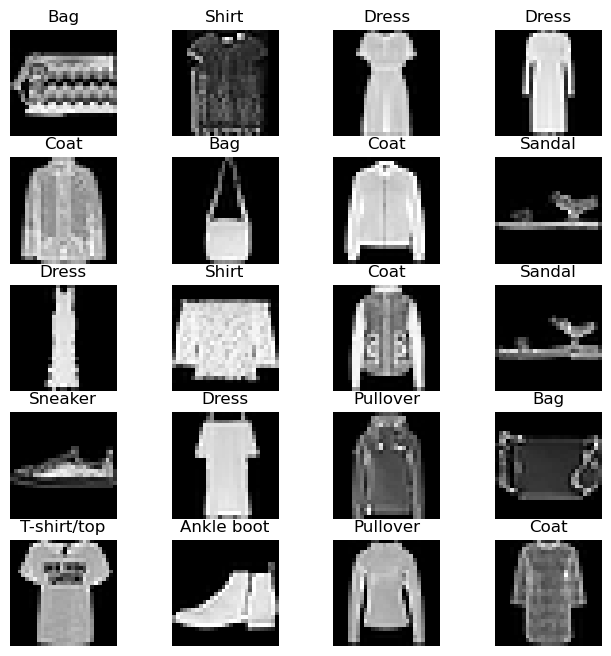

In [6]:
labels_map = {0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5

for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0].squeeze() # 1, 28, 28 -> 28, 28
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()


In [14]:
# 합성곱 신경망이 아닌 심층 신경망을 사용하여 학습

class FashionDNN(nn.Module):
    def __init__(self) -> None:
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data:torch.Tensor):
        out = input_data.view(-1, 784)
        out = F.relu6(self.fc1(out))
        out = self.drop(out)
        out = F.relu6(self.fc2(out))
        out = self.fc3(out)
        return out


model = FashionDNN()
model.to(device)
model

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
# 모델 학습
lr = 0.001
criterion = nn.CrossEntropyLoss() # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 5
count = 0

loss_lst = []
iter_lst = []
acc_lst = []

pred_lst = []
labels_lst = []

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs,labels = imgs.to(device), labels.to(device)

        train = Variable(imgs.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                labels_lst.append(labels)
                test = Variable(imgs.view(100, 1, 28, 28))
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_lst.append(pred)
                correct += (pred == labels).sum()
                total += len(labels)
            
            acc = correct * 100 / total
            loss_lst.append(loss.data)
            iter_lst.append(count)
            acc_lst.append(acc)
        
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {acc}")

Iteration: 500, Loss: 0.629956841468811, Accuracy: 85.35000610351562
Iteration: 1000, Loss: 0.3259488642215729, Accuracy: 85.7800064086914
Iteration: 1500, Loss: 0.32006770372390747, Accuracy: 85.6300048828125
Iteration: 2000, Loss: 0.35881587862968445, Accuracy: 85.60000610351562
Iteration: 2500, Loss: 0.23552992939949036, Accuracy: 86.20000457763672
Iteration: 3000, Loss: 0.2595367431640625, Accuracy: 86.4000015258789


In [7]:
# 합성곱 신경망

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # 일렬로 펴주기
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = FashionCNN()
model.to(device)
model

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [8]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 5
count = 0

loss_lst = []
iter_lst = []
acc_lst = []

pred_lst = []
labels_lst = []

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        train = Variable(imgs)
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                labels_lst.append(labels)
                test = Variable(imgs)
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_lst.append(pred)
                correct += (pred == labels).sum()
                total += len(labels)
            
            acc = correct * 100 / total
            loss_lst.append(loss.data)
            iter_lst.append(count)
            acc_lst.append(acc)
        
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {acc}")
            

Iteration: 500, Loss: 0.47862598299980164, Accuracy: 88.4800033569336
Iteration: 1000, Loss: 0.2834702134132385, Accuracy: 87.87000274658203
Iteration: 1500, Loss: 0.3127710223197937, Accuracy: 88.50000762939453
Iteration: 2000, Loss: 0.2058054655790329, Accuracy: 89.0300064086914
Iteration: 2500, Loss: 0.11944931745529175, Accuracy: 90.20000457763672
Iteration: 3000, Loss: 0.15965433418750763, Accuracy: 90.30000305175781


In [11]:
# 전이 학습

import cv2
import os
import time
import copy
import glob
import shutil

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [14]:
data_path = './data/catanddog/train'

transform = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지 크기 조정
    transforms.RandomResizedCrop(224), # 이미지를 랜덤으로 자름
    transforms.RandomHorizontalFlip(), # 이미지를 랜덤으로 좌우 반전
    transforms.ToTensor(), # 텐서로 변환
])

# 데이터 불러오기
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)

# 데이터를 불러올 때 배치 사이즈만큼 불러옴
# num_workers : 데이터를 불러올 프로세스 수
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)

len(train_dataset)

529

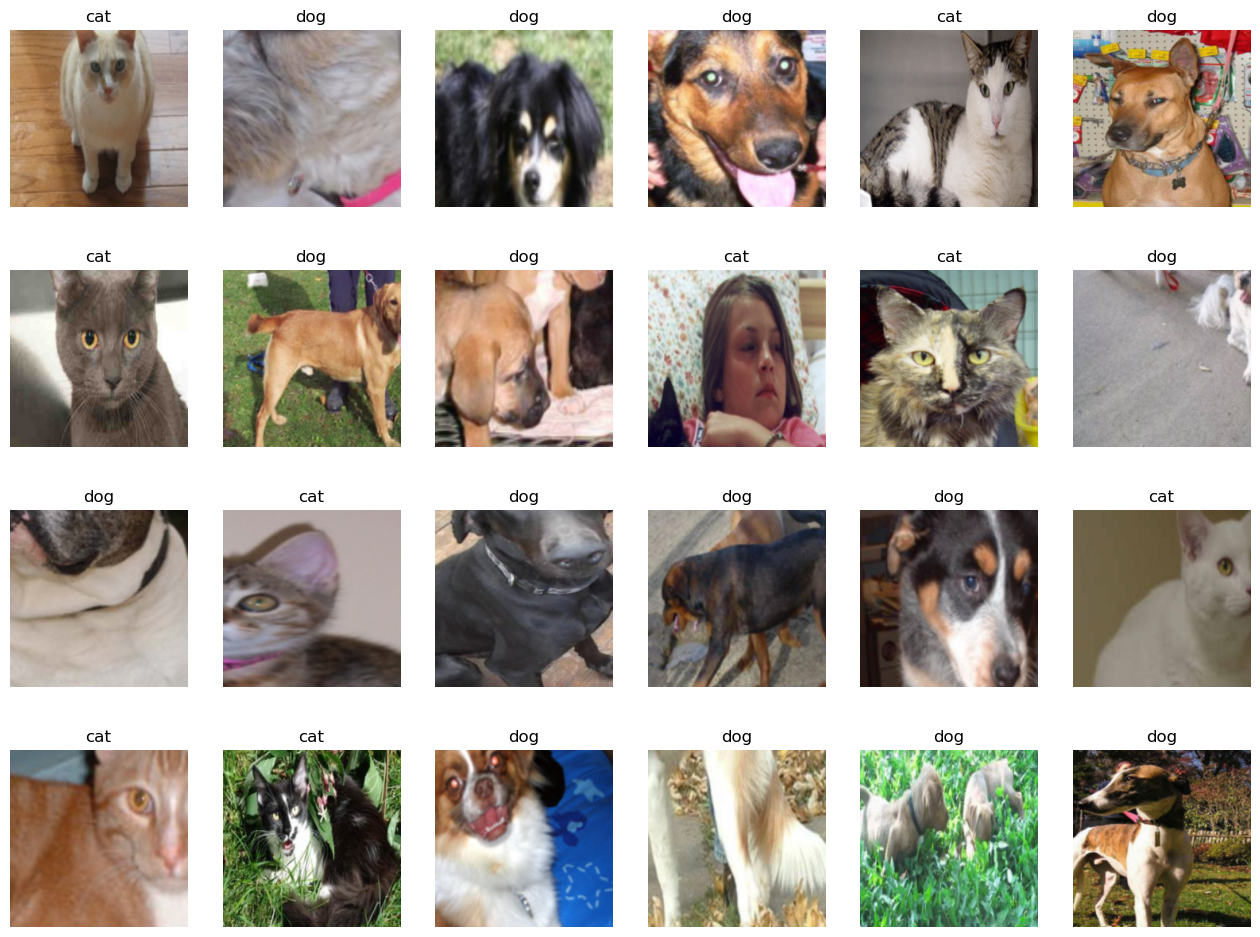

In [18]:
samples, labels = next(iter(train_loader))
classes = {0 : 'cat', 1 : 'dog'}
fig = plt.figure(figsize=(16, 24))
for i in range(1, 25):
    a = fig.add_subplot(4, 6, i)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0))) # (3, 224, 224) -> (224, 224, 3)

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [25]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


model.fc == nn.Linear(in_features=512, out_features=2)

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
cost = nn.CrossEntropyLoss()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.to(device)

            optimizer.zero_grad() # 기울기 초기화
            outputs = model(inputs) # 모델에 입력값을 넣어 결과값을 얻음
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1) # 가장 큰 값의 인덱스를 얻음
            loss.backward() # 역전파
            optimizer.step() # 가중치 갱신

            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적해서 저장
            running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 일치한 경우를 누적해서 저장
        
        epoch_loss = running_loss / len(dataloaders.dataset) # epoch당 평균 오차를 계산
        epoch_acc = running_corrects.float() / len(dataloaders.dataset) # epoch당 평균 정확도를 계산
        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        if os.path.exists('./models') is False:
            os.mkdir('./models')
        torch.save(model.state_dict(), os.path.join('./models', '{0:0=2d}.pth'.format(epoch)))

        print()

    time_elapsed = time.time() - since # 학습하는데 걸린 시간
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Acc: {best_acc:4f}")

    return acc_history, loss_history

In [35]:

device = torch.device('mps')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device, num_epochs=13, is_train=True)

Epoch 0/12
----------
Loss: 0.3108 Acc: 0.8582

Epoch 1/12
----------
Loss: 0.2615 Acc: 0.8809

Epoch 2/12
----------
Loss: 0.2559 Acc: 0.8998

Epoch 3/12
----------
Loss: 0.2295 Acc: 0.9112

Epoch 4/12
----------
Loss: 0.2158 Acc: 0.9036

Epoch 5/12
----------
Loss: 0.2104 Acc: 0.9093

Epoch 6/12
----------
Loss: 0.2548 Acc: 0.8922

Epoch 7/12
----------
Loss: 0.2343 Acc: 0.8828

Epoch 8/12
----------
Loss: 0.2551 Acc: 0.8847

Epoch 9/12
----------
Loss: 0.1911 Acc: 0.9225

Epoch 10/12
----------
Loss: 0.1743 Acc: 0.9319

Epoch 11/12
----------
Loss: 0.2388 Acc: 0.8715

Epoch 12/12
----------
Loss: 0.2305 Acc: 0.8979

Training complete in 9m 54s
Best Acc: 0.931947


In [ ]:
test_path = './data/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)